**Authors:**

Daniel Vila de la Cruz

Sara Gómez Feás

In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Introduction

The objective of this project is to employ various recurrent neural network architectures to address a classification problem. To achieve this, we will be utilizing the Amazon Reviews for Sentiment Analysis dataset, which is available on Kaggle. The specific task that we will be tackling involves classifying customer reviews into two categories: _label_1 for 1-2 star reviews and _label_2 for 4-5 star reviews.

Given the nature of the problem, we will be using accuracy as the key performance metric to evaluate the effectiveness of the models.

# 2. Prepare dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#reads a file. Each line has the format: label text
#Returns a list with the text and a list with the labels
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))
    
    for i, aLine in enumerate(lines):     
        if not aLine:
            break  
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            textData.append(aLine.removeprefix("__label__1 "))

        elif(label == "__label__2"):
            textLabel.append(1)
            textData.append(aLine.removeprefix("__label__2 "))

        else:
            print("\nError in readData: ", i, aLine)
            exit()
    
    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))

In [6]:
def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    #transforms text input to int input based on the vocabulary
    #max_tokens = maxFeatures is the size of the vocabulary
    #output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
    precLayer = layers.experimental.preprocessing.TextVectorization(max_tokens = maxFeatures, 
    standardize =  'lower_and_strip_punctuation', split = 'whitespace', output_mode = 'int', 
    output_sequence_length =  seqLength)
    precLayer.adapt(x_train)
    #print(precLayer.get_vocabulary())
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    #print(x_train_int)
    #print(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)
    #print(x_test_int)
    #print(y_test)

    return x_train_int, y_train, x_test_int, y_test

In [7]:
x_train, y_train, seqLength = readData("/content/drive/MyDrive/DL/P2_RNN/amazon/train_small.txt")
x_test, y_test, tmp = readData("/content/drive/MyDrive/DL/P2_RNN/amazon/test_small.txt")

#maxFeatures is a hyperparameter
maxFeatures = 2000
#maxFeatures = 20000

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, 
maxFeatures, seqLength)

# 3. Models

We will try different models based on simple RNNs, LSTMs, GRUs, and other variations of recurrent neural networks.

## 3.1. Simple RNN model

This first model is based on a simple RNN architecture. 

The input layer takes in the text data and transforms it into a continuous vector space using an embedding layer, which maps each word in the input text to a dense vector with 30 dimensions. The embedded data is then fed into a simple RNN layer with 128 units. To introduce nonlinearity to the model and help it learn more complex representations of the input data, the output of the RNN layer is passed through a dense layer with 16 units and a ReLU activation function. Finally, the output of the dense layer is passed through another dense layer with a single unit and a sigmoid activation function, which produces a probability value between 0 and 1 indicating the predicted sentiment of the review (0 for negative and 1 for positive).

In [ ]:
inputs = keras.Input(shape=(seqLength,), name="Input_Layer")
x = layers.Embedding(maxFeatures, output_dim=30)(inputs)
x = layers.SimpleRNN(128, name="RNN_1")(x)
x = layers.Dense(16, activation="relu", name="Dense_1")(x)
outputs = layers.Dense(1, activation="sigmoid", name="Dense_2")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 30)           60000     
                                                                 
 RNN_1 (SimpleRNN)           (None, 128)               20352     
                                                                 
 Dense_1 (Dense)             (None, 16)                2064      
                                                                 
 Dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 82,433
Trainable params: 82,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_int, y_train, batch_size=64, epochs=30, validation_data = (x_test_int, y_test), callbacks = [early_stop])

Epoch 1/30
391/391 [==============================] - 138s 335ms/step - loss: 0.7000 - accuracy: 0.4988 - val_loss: 0.7114 - val_accuracy: 0.4746
Epoch 2/30
391/391 [==============================] - 92s 235ms/step - loss: 0.6960 - accuracy: 0.5102 - val_loss: 0.7083 - val_accuracy: 0.5137
Epoch 3/30
391/391 [==============================] - 87s 223ms/step - loss: 0.6936 - accuracy: 0.5118 - val_loss: 0.6901 - val_accuracy: 0.5106
Epoch 4/30
391/391 [==============================] - 84s 214ms/step - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0.6895 - val_accuracy: 0.5120
Epoch 5/30
391/391 [==============================] - 79s 203ms/step - loss: 0.6921 - accuracy: 0.5063 - val_loss: 0.6903 - val_accuracy: 0.5137
Epoch 6/30
391/391 [==============================] - 85s 216ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6901 - val_accuracy: 0.5169
Epoch 7/30
391/391 [==============================] - 83s 213ms/step - loss: 0.6914 - accuracy: 0.5149 - val_loss: 0.6880 - val_a

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_int, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

782/782 [==============================] - 14s 18ms/step - loss: 0.6880 - accuracy: 0.5173
Test accuracy: 0.52


The results show that the model achieved a test accuracy of 0.52, which is only slightly better than random guessing. This suggests that the model is not effective at classifying sentiment based on the input text data.

The simple RNN model may not be complex enough to effectively capture the features and patterns in the input text data.

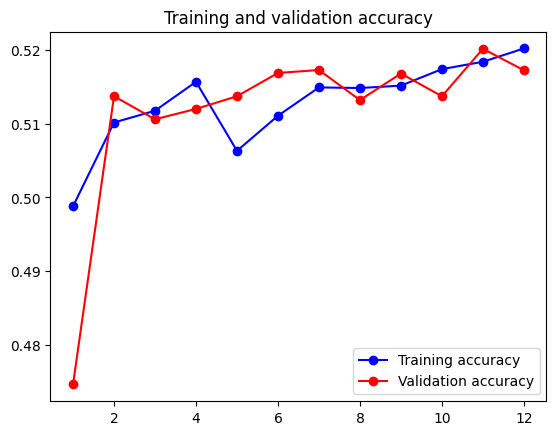

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()


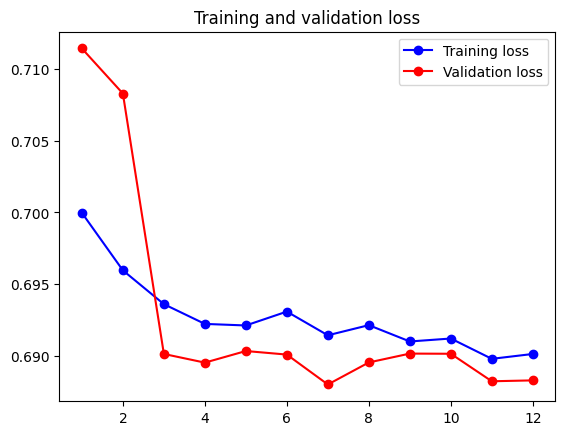

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## 3.2. LSTM models

### 3.2.1. First LSTM model

This second model includes two LSTM layers, with 128 and 64 units respectively. The first LSTM layer has the return_sequences parameter set to True, allowing it to learn more complex representations of the input data. The final layer is again a dense layer with a single unit and a sigmoid activation function. 

Overall, this architecture has the potential to learn more complex representations of the input data compared to the simple RNN model, due to the increased depth and complexity of the LSTM layers.

In [ ]:
inputs = keras.Input(shape=(seqLength,), name="Input_Layer")
x = layers.Embedding(maxFeatures, output_dim=30)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 30)           60000     
                                                                 
 lstm_2 (LSTM)               (None, 166, 128)          81408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 190,881
Trainable params: 190,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_int, y_train, batch_size=64, epochs=30, validation_data = (x_test_int, y_test), callbacks = [early_stop])

Epoch 1/30
391/391 [==============================] - 37s 83ms/step - loss: 0.6930 - accuracy: 0.5160 - val_loss: 0.6927 - val_accuracy: 0.5138
Epoch 2/30
391/391 [==============================] - 13s 34ms/step - loss: 0.6795 - accuracy: 0.5224 - val_loss: 0.6736 - val_accuracy: 0.5310
Epoch 3/30
391/391 [==============================] - 12s 31ms/step - loss: 0.6725 - accuracy: 0.5314 - val_loss: 0.6737 - val_accuracy: 0.5301
Epoch 4/30
391/391 [==============================] - 11s 27ms/step - loss: 0.6723 - accuracy: 0.5256 - val_loss: 0.6758 - val_accuracy: 0.5137
Epoch 5/30
391/391 [==============================] - 9s 22ms/step - loss: 0.6720 - accuracy: 0.5268 - val_loss: 0.6737 - val_accuracy: 0.5158
Epoch 6/30
391/391 [==============================] - 10s 25ms/step - loss: 0.6717 - accuracy: 0.5286 - val_loss: 0.6735 - val_accuracy: 0.5312
Epoch 7/30
391/391 [==============================] - 10s 25ms/step - loss: 0.6723 - accuracy: 0.5280 - val_loss: 0.6739 - val_accuracy: 

The model was trained for 11 epochs, but early stopping was triggered after the 6th epoch, as the validation loss did not improve for 5 consecutive epochs.

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_int, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

782/782 [==============================] - 6s 8ms/step - loss: 0.6735 - accuracy: 0.5312
Test accuracy: 0.53


After evaluating the model on the test set, it achieved a test accuracy of 0.53 with a loss of 0.6735. 

While this model was more complex and had the potential to learn more complex representations of the input data compared to the simple RNN model, it did not perform significantly better.

The plot of the training and validation accuracy for the LSTM model shows several peaks and dips, indicating that the model's performance fluctuated during training. In addition, the fact that the validation loss is consistently slightly higher than the training loss suggests that the model is not generalizing well to new data.

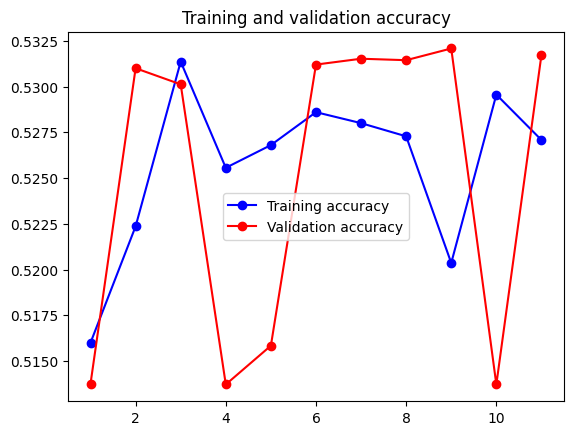

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

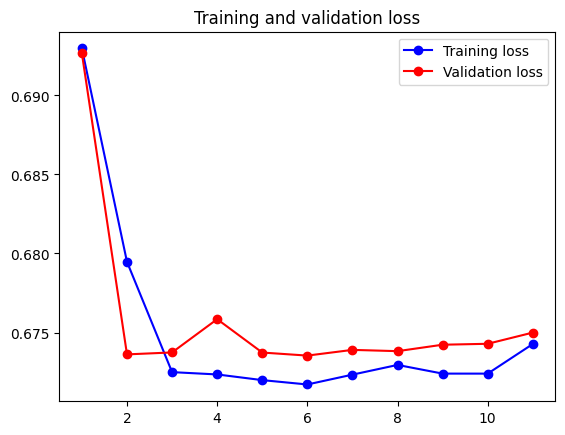

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 3.2.2. Second LSTM model

In an attempt to improve the performance of the previous LSTM model, we will now try a more complex architecture. This new model will consist of two bidirectional LSTM layers with dropout regularization to prevent overfitting. The first LSTM layer will have 128 units and the second LSTM layer will have 64 units. 

This new architecture is expected to learn more complex representations of the input data and hopefully improve the model's performance on the sentiment analysis task.

In [ ]:
inputs = keras.Input(shape=(seqLength,), name="Input_Layer")
x = layers.Embedding(maxFeatures, output_dim=30)(inputs)
x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True))(x)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.LSTM(units=64))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 166)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 166, 30)           60000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 166, 256)         162816    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 166, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0   

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_int, y_train, batch_size=64, epochs=30, validation_data = (x_test_int, y_test), callbacks = [early_stop])

Epoch 1/30
391/391 [==============================] - 50s 105ms/step - loss: 0.4386 - accuracy: 0.7876 - val_loss: 0.3426 - val_accuracy: 0.8549
Epoch 2/30
391/391 [==============================] - 21s 53ms/step - loss: 0.3016 - accuracy: 0.8746 - val_loss: 0.3270 - val_accuracy: 0.8605
Epoch 3/30
391/391 [==============================] - 19s 49ms/step - loss: 0.2613 - accuracy: 0.8961 - val_loss: 0.3040 - val_accuracy: 0.8739
Epoch 4/30
391/391 [==============================] - 19s 50ms/step - loss: 0.2362 - accuracy: 0.9092 - val_loss: 0.3038 - val_accuracy: 0.8752
Epoch 5/30
391/391 [==============================] - 18s 46ms/step - loss: 0.2184 - accuracy: 0.9167 - val_loss: 0.3191 - val_accuracy: 0.8715
Epoch 6/30
391/391 [==============================] - 19s 48ms/step - loss: 0.2091 - accuracy: 0.9188 - val_loss: 0.3215 - val_accuracy: 0.8696
Epoch 7/30
391/391 [==============================] - 18s 47ms/step - loss: 0.1890 - accuracy: 0.9302 - val_loss: 0.3365 - val_accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_int, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

782/782 [==============================] - 10s 12ms/step - loss: 0.3038 - accuracy: 0.8752
Test accuracy: 0.88


Overall, the results suggest that this model was successful in improving the previous model's performance on the sentiment analysis task, achieving a test accuracy of 88%. However, the early stopping callback was triggered at epoch 9, indicating that the model started to overfit relatively early in the training process.

Furthermore, if we look at the accuracy graphs, we can see that the validation accuracy remains around 0.86-0.88 throughout the training, while the training accuracy continues to increase, reaching 0.94 in epoch 9. This indicates that the model has reached its learning limit on this dataset.

In contrast, in the loss graph, we can see that the training loss decreases with each epoch, while the validation loss continues to increase, always being higher than the training loss from epoch 2 onwards. This suggest that the model is overfitting to the training data.

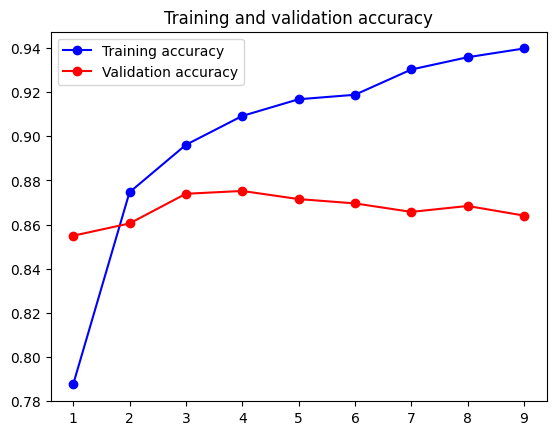

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

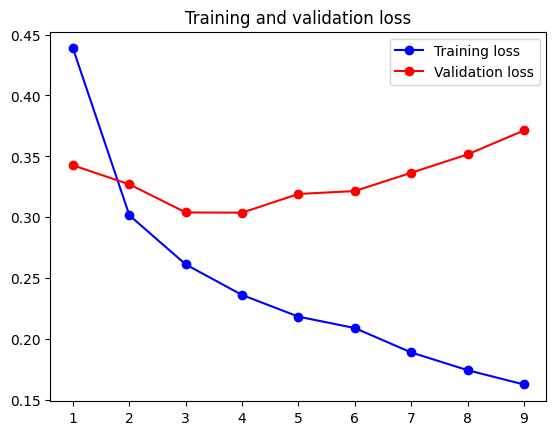

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## 3.3. GRU models

### 3.3.1. First GRU model

This fisrt model consists of two GRU layers. The first GRU layer with 64 units and the second GRU layer with 32 units. As in the previous models, the output layer consist on a dense layer with a single unit and a sigmoid activation function.

In [ ]:
inputs = keras.Input(shape=(seqLength,), name="Input_Layer")
x = layers.Embedding(maxFeatures, output_dim=30)(inputs)
x = layers.GRU(units=64, return_sequences=True)(x)
x = layers.GRU(units=32)(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 166)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 166, 30)           60000     
                                                                 
 gru_2 (GRU)                 (None, 166, 64)           18432     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87,873
Trainable params: 87,873
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_int, y_train, batch_size=64, epochs=30, validation_data = (x_test_int, y_test), callbacks =[early_stop])

Epoch 1/30
391/391 [==============================] - 37s 83ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6935 - val_accuracy: 0.5137
Epoch 2/30
391/391 [==============================] - 12s 31ms/step - loss: 0.6929 - accuracy: 0.5181 - val_loss: 0.6927 - val_accuracy: 0.5174
Epoch 3/30
391/391 [==============================] - 11s 28ms/step - loss: 0.6860 - accuracy: 0.5388 - val_loss: 0.6459 - val_accuracy: 0.6194
Epoch 4/30
391/391 [==============================] - 10s 26ms/step - loss: 0.4344 - accuracy: 0.7992 - val_loss: 0.3407 - val_accuracy: 0.8529
Epoch 5/30
391/391 [==============================] - 8s 20ms/step - loss: 0.2802 - accuracy: 0.8833 - val_loss: 0.2859 - val_accuracy: 0.8813
Epoch 6/30
391/391 [==============================] - 10s 26ms/step - loss: 0.2279 - accuracy: 0.9091 - val_loss: 0.2688 - val_accuracy: 0.8886
Epoch 7/30
391/391 [==============================] - 10s 26ms/step - loss: 0.2023 - accuracy: 0.9215 - val_loss: 0.2725 - val_accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_int, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

782/782 [==============================] - 6s 8ms/step - loss: 0.2688 - accuracy: 0.8886
Test accuracy: 0.89


The test accuracy achieved by this model is 0.89, indicating a significant improvement over previous models. This suggests that using GRU layers could be a better option for this sentiment analysis task. However, the training process shows that this model is overfitting. This is evident in the graphs, as the validation loss surpasses the training loss from epoch 6 onwards. This means that the model is memorizing the training data, which causes it to be unable to generalize to new, unseen data.

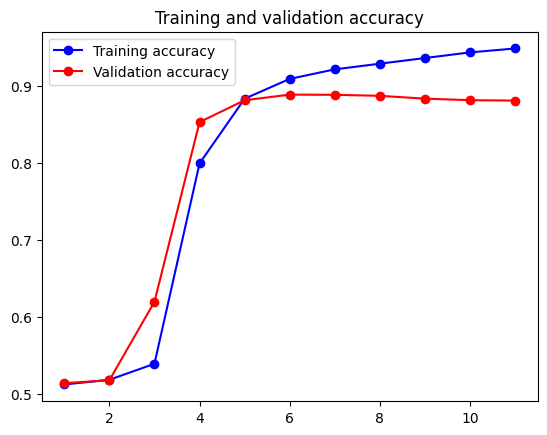

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

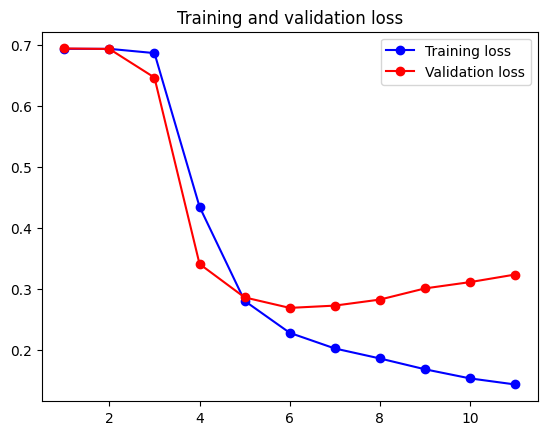

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 3.3.2. Second GRU model

This next model architecture consists of a bidirectional GRU layer with 256 units, a dropout layer with a rate of 0.2, another bidirectional GRU layer with 128 units and a dense layer with a single unit and a sigmoid activation function.

In [ ]:
from keras.layers import GRU

inputs = keras.Input(shape=(seqLength,), name="Input_Layer")
x = layers.Embedding(maxFeatures, output_dim=30)(inputs)
x = layers.Bidirectional(GRU(units=256, return_sequences=True))(x)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(GRU(units=128))(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 166)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 166, 30)           60000     
                                                                 
 bidirectional (Bidirectiona  (None, 166, 512)         442368    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 166, 512)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              493056    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 257 

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_int, y_train, batch_size=64, epochs=30, validation_data = (x_test_int, y_test), callbacks=[early_stop])

Epoch 1/30
391/391 [==============================] - 64s 142ms/step - loss: 0.4232 - accuracy: 0.7980 - val_loss: 0.3424 - val_accuracy: 0.8530
Epoch 2/30
391/391 [==============================] - 26s 68ms/step - loss: 0.2975 - accuracy: 0.8770 - val_loss: 0.2961 - val_accuracy: 0.8782
Epoch 3/30
391/391 [==============================] - 27s 68ms/step - loss: 0.2527 - accuracy: 0.8996 - val_loss: 0.2826 - val_accuracy: 0.8833
Epoch 4/30
391/391 [==============================] - 29s 74ms/step - loss: 0.2157 - accuracy: 0.9161 - val_loss: 0.2852 - val_accuracy: 0.8826
Epoch 5/30
391/391 [==============================] - 26s 67ms/step - loss: 0.1863 - accuracy: 0.9297 - val_loss: 0.2828 - val_accuracy: 0.8890
Epoch 6/30
391/391 [==============================] - 30s 77ms/step - loss: 0.1681 - accuracy: 0.9374 - val_loss: 0.2685 - val_accuracy: 0.8954
Epoch 7/30
391/391 [==============================] - 29s 74ms/step - loss: 0.1443 - accuracy: 0.9470 - val_loss: 0.2980 - val_accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_int, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

782/782 [==============================] - 12s 16ms/step - loss: 0.2685 - accuracy: 0.8954
Test accuracy: 0.90


The training process was run for 11 epochs, but the best performance on the validation set was achieved at epoch 6. After epoch 6, the validation accuracy begins to plateau and even decrease, indicating that the model is overfitting to the training data. 

Overall, the model achieves a test accuracy of around 90% (0.895), which is reasonably good.

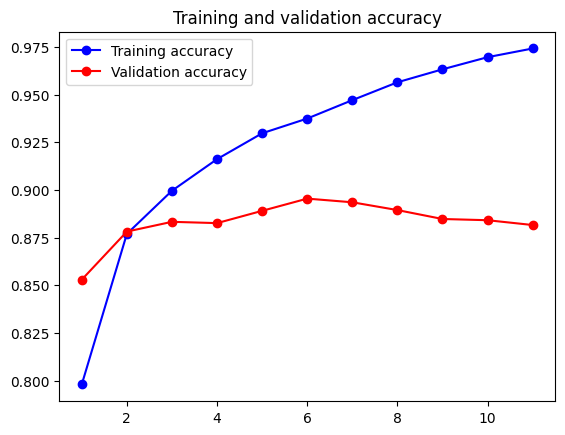

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

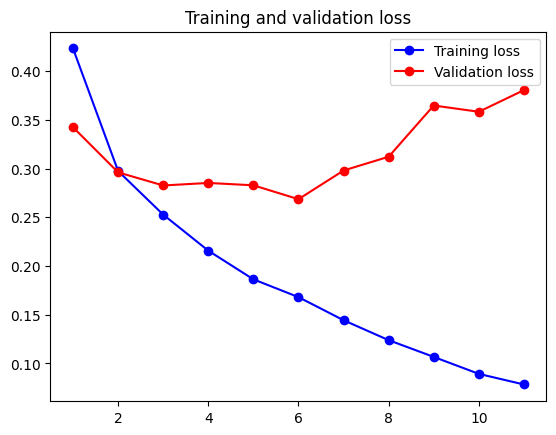

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 3.3.3. Third GRU model

Our previous models were overfitting on the first epochs, so to try to avoid it, we have increased the maxFeatures hyperparameter to 20000, reduced the number of units of the GRU layers, added two BatchNormalization layers,stablished a L2 kernel regularizer and use a low learning rate. With those changes we pretend to slow the training phase and use a less complex model, so the validation accuracy can be closer to the training one. We also tried different optimizers, being RMSprop the one bringing better results.

In [12]:
from keras.layers import GRU
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(seqLength,), name="Input_Layer")
x = layers.Embedding(maxFeatures, output_dim=30)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Bidirectional(GRU(units=4,  kernel_regularizer=regularizers.l2(0.001)))(x)
x = layers.BatchNormalization()(x)

outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 30)           600000    
                                                                 
 batch_normalization_4 (Batc  (None, 166, 30)          120       
 hNormalization)                                                 
                                                                 
 bidirectional_2 (Bidirectio  (None, 8)                864       
 nal)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                           

In [13]:
opt = keras.optimizers.RMSprop(learning_rate=0.00003) 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_int, y_train, batch_size=64, epochs=30, validation_data = (x_test_int, y_test), callbacks=[early_stop])

Epoch 1/30
391/391 [==============================] - 44s 99ms/step - loss: 0.7620 - accuracy: 0.5890 - val_loss: 0.8472 - val_accuracy: 0.5141
Epoch 2/30
391/391 [==============================] - 18s 45ms/step - loss: 0.6470 - accuracy: 0.6725 - val_loss: 0.6284 - val_accuracy: 0.6881
Epoch 3/30
391/391 [==============================] - 14s 36ms/step - loss: 0.5889 - accuracy: 0.7173 - val_loss: 0.5870 - val_accuracy: 0.7175
Epoch 4/30
391/391 [==============================] - 12s 31ms/step - loss: 0.5523 - accuracy: 0.7440 - val_loss: 0.5616 - val_accuracy: 0.7343
Epoch 5/30
391/391 [==============================] - 11s 28ms/step - loss: 0.5261 - accuracy: 0.7618 - val_loss: 0.5410 - val_accuracy: 0.7470
Epoch 6/30
391/391 [==============================] - 10s 24ms/step - loss: 0.5025 - accuracy: 0.7786 - val_loss: 0.5239 - val_accuracy: 0.7600
Epoch 7/30
391/391 [==============================] - 10s 25ms/step - loss: 0.4835 - accuracy: 0.7907 - val_loss: 0.5095 - val_accuracy:

In [14]:
test_loss, test_accuracy = model.evaluate(x_test_int, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

782/782 [==============================] - 5s 6ms/step - loss: 0.3271 - accuracy: 0.8711
Test accuracy: 0.87


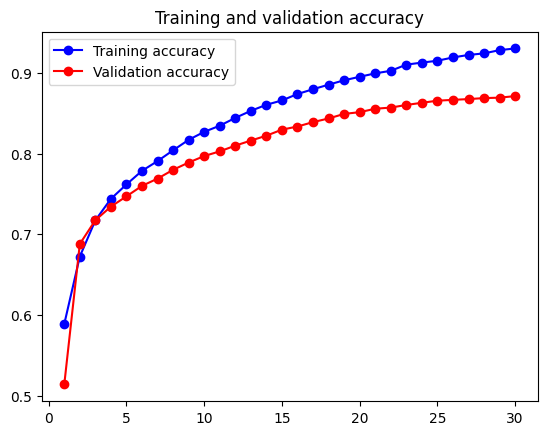

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

Exception ignored in: <function _xla_gc_callback at 0x7f2ae67e58b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


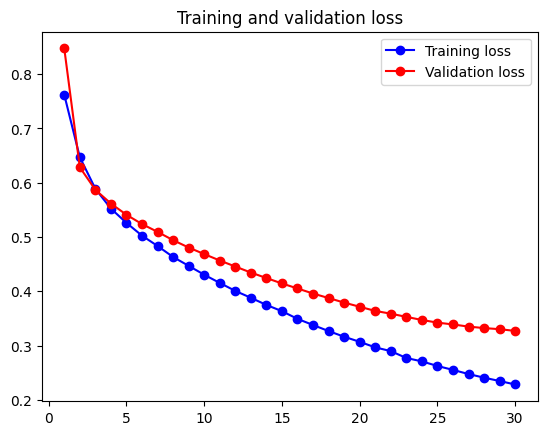

In [16]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


This model presents a way better learning curve, but the results are slighly worse than the previous models, as it presents a test accuracy of 0.8711 and a loss of 0.3271. We also tried training the same model on 150 epochs, as the early stop parametter did not stop the training process on 30 epochs, but after doing it we saw that the model starts overfitting around epoch 30, without any noticeable improvement regarding accuracy or loss.

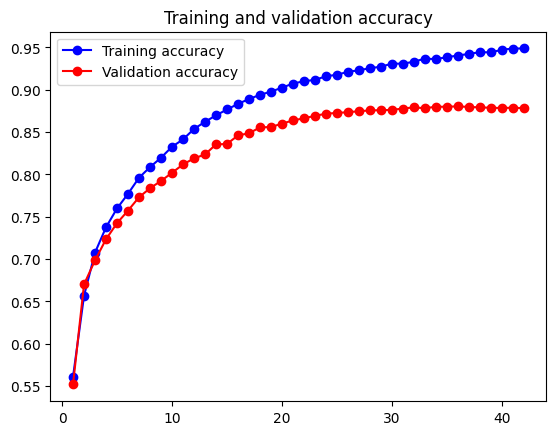

In [21]:
# Accuracy with 150 epochs

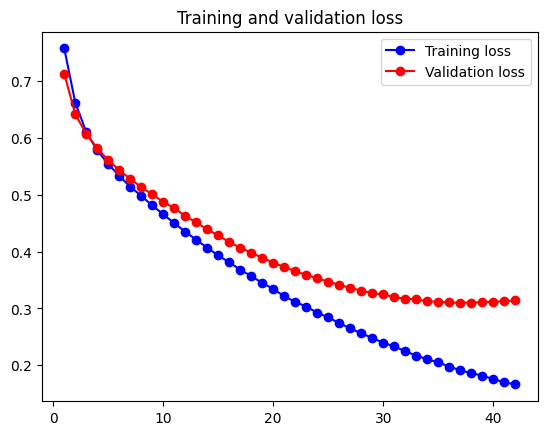

In [22]:
# Loss with 150 epochs

# 4. Conclusions

Let's make a comparison of the models' performance.

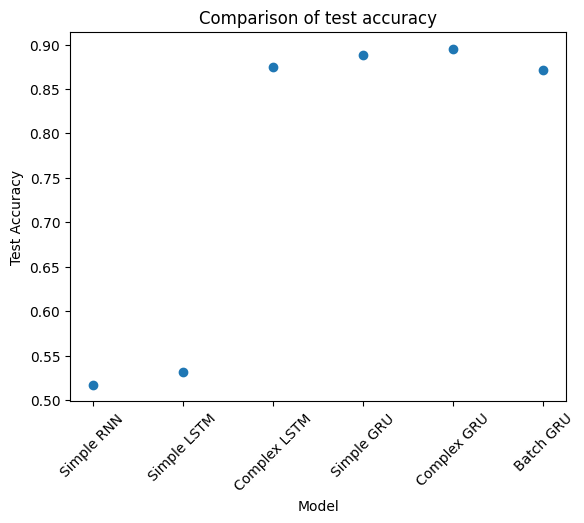

In [30]:
import matplotlib.pyplot as plt

# test accuracies of each model
test_accuracies = [0.5173, 0.5312, 0.8752, 0.8886, 0.8954, 0.8711]
# model names
model_names = ['Simple RNN', 'Simple LSTM', 'Complex LSTM', 'Simple GRU', 'Complex GRU', 'Batch GRU']
# plot test accuracies as points
plt.scatter(model_names, test_accuracies)
# set plot title and axis labels
plt.title('Comparison of test accuracy')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')

plt.xticks(rotation=45)

# show plot
plt.show()

The Simple RNN (3.1.) and Simple LSTM (3.2.1.) models perform poorly compared to the other models, likely due to their limited capacity to remember long-term dependencies in the input text. The Simple GRU (3.3.1.) , Complex LSTM (3.2.2.) , Complex GRU (3.3.2.) and Batch GRU (3.3.3) models achieve much higher accuracy rates, with the Complex GRU model outperforming the other three.

Our target was to achieve a classification accuracy of at least 84% on the test set, which all three of these last models successfully reached.

Therefore, it can be concluded that models with bidirectional layers perform better for sentiment analysis on this dataset.